<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span><ul class="toc-item"><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Предобработка данных</a></span></li></ul></li><li><span><a href="#Подготовка-данных-к-машинному-обучению" data-toc-modified-id="Подготовка-данных-к-машинному-обучению-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных к машинному обучению</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод:</a></span></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Анализ моделей</a></span><ul class="toc-item"><li><span><a href="#Общий-вывод:" data-toc-modified-id="Общий-вывод:-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Общий вывод:</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. Что в свою очередь повлияет на скорость продажи автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам необходимо построить модель для более точного определения стоимости, при этом так же важна скорость работы. Что явлется классическим примером **MVP** в стартапах. Где самая сложная его задача это нехватка дополнительной информации и использование ее для поиска наилучшего качества моделей.

*Немного юмора*)))

![как MVP делать не нужно](https://upload.wikimedia.org/wikipedia/commons/8/89/Mvp_%28minimum_viable_product%29.png)


**Заказчику важны:**

- качество предсказания;
- скорость предсказания;
- время обучения.

Для оценки качества моделей будем применять метрику **RMSE**.
Значение метрики **RMSE** должно быть меньше **2500**.


# Описание данных


**Признаки**

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя


**Целевой признак**

- Price — цена (евро)



## Загрузка данных

In [1]:
#импортируем нужные библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


!pip install geopy
from geopy.geocoders import Nominatim

!pip install folium
import folium


pd.set_option("display.max_rows",80)
pd.set_option('max_colwidth', None)
pd.set_option("display.float_format", "{:,.2f}".format)
sns.set(style="whitegrid", palette="Pastel1")


#для проверки корреляции признаков
!pip install phik
import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix


import warnings
warnings.filterwarnings('ignore')

!pip install lightgbm

!pip install category_encoders

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import (
                Ridge, 
                LinearRegression
)
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import (
                Pipeline, 
                make_pipeline
)

from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ( 
                train_test_split,
                GridSearchCV,
                cross_val_score
)
from sklearn.metrics import (
    mean_squared_error, 
    make_scorer
)


RANDOM_STATE = 555

In [2]:
#выгружаем наши данные
try:
    df = pd.read_csv('/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
except FileNotFoundError:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

In [3]:
#функция для быстрого просмотра данных
def information(df: 'DataFrame', name: 'str') -> None:
    print('*'*30,name,'*'*30)
    print()
    display(df.head(3))
    print('-'*25,'INFO','-'*25)
    print()
    display(df.info())
    print()
    print('-'*10,'NAN','-'*10)
    print()
    display(df.isna().sum())
    display(pd.DataFrame(round(df.isna().mean()*100,1)).sort_values(by=0, ascending=False).style.background_gradient('coolwarm'))
    print()
    print('-'*5,'DESCRIBE','-'*5)
    display(df.describe())
    print()
    print('-'*5,'DUPLICATED','-'*5)
    display(df.duplicated().sum())
    print()
    print('-'*25,'UNIQUE VALUES','-'*25)
    for column in df.columns:
        display(column)
        display(len(df[column].unique()))
        print('+'*25)
    print("-"*100)

In [4]:
information(df, 'Авто')

****************************** Авто ******************************



,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46


------------------------- INFO -------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  dateti

None


---------- NAN ----------



DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

,0
Repaired,20.100000
VehicleType,10.600000
FuelType,9.300000
Gearbox,5.600000
Model,5.600000
DateCrawled,0.000000
Price,0.000000
RegistrationYear,0.000000
Power,0.000000
Kilometer,0.000000



----- DESCRIBE -----


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,"354,369.00","354,369.00","354,369.00","354,369.00","354,369.00","354,369.00","354,369.00"
mean,"4,416.66","2,004.23",110.09,"128,211.17",5.71,0.00,"50,508.69"
std,"4,514.16",90.23,189.85,"37,905.34",3.73,0.00,"25,783.10"
min,0.00,"1,000.00",0.00,"5,000.00",0.00,0.00,"1,067.00"
25%,"1,050.00","1,999.00",69.00,"125,000.00",3.00,0.00,"30,165.00"
50%,"2,700.00","2,003.00",105.00,"150,000.00",6.00,0.00,"49,413.00"
75%,"6,400.00","2,008.00",143.00,"150,000.00",9.00,0.00,"71,083.00"
max,"20,000.00","9,999.00","20,000.00","150,000.00",12.00,0.00,"99,998.00"



----- DUPLICATED -----


4


------------------------- UNIQUE VALUES -------------------------


'DateCrawled'

271174

+++++++++++++++++++++++++


'Price'

3731

+++++++++++++++++++++++++


'VehicleType'

9

+++++++++++++++++++++++++


'RegistrationYear'

151

+++++++++++++++++++++++++


'Gearbox'

3

+++++++++++++++++++++++++


'Power'

712

+++++++++++++++++++++++++


'Model'

251

+++++++++++++++++++++++++


'Kilometer'

13

+++++++++++++++++++++++++


'RegistrationMonth'

13

+++++++++++++++++++++++++


'FuelType'

8

+++++++++++++++++++++++++


'Brand'

40

+++++++++++++++++++++++++


'Repaired'

3

+++++++++++++++++++++++++


'DateCreated'

109

+++++++++++++++++++++++++


'NumberOfPictures'

1

+++++++++++++++++++++++++


'PostalCode'

8143

+++++++++++++++++++++++++


'LastSeen'

179150

+++++++++++++++++++++++++
----------------------------------------------------------------------------------------------------


# **Вывод**


Итак у нас датасет достаточно сырой, имеется большое количество пропусков, и даны признаки, не сильно связные, нам предстоит распутать этот клубок. И понять на собственном опыте что означает принцип **GIGO** ;) или же **«что посеешь, то и пожнёшь»**

- Мы имеем датасет состоящий из 354369 строк и 16 столбцов
- Очень большое количество пропусков в данных
- У нас имеется три столбца с временными метками, что заведомо дает понять что нужно будет быть аккуратнее, чтобы не допустить переобучения
- Мы имеем признак с индексами, что так же намекает скорее всего на географическое разделение данных, что всегда имеет важность
- По распределению в некоторых непрерывных данных видим искажения
- 4 строки дубликатов
- В двух категориальных данных имеется большое количество уникальных значений, что говорит у том, что придется так же бороться с размерностью в данных
- Один признак отсекается сразу, это количество фотографий в анкете, странно, но почему-то нет фотографий, все по нулям.



### Предобработка данных

In [5]:
#сохраним размер нашего датасета
size = df.shape[0]
size

354369

In [6]:
#Приведем признаки к нижнему регистру и змеиному стилю
df.columns = df.columns.str.lower()

df = df.rename(columns = 
               {
                     'datecrawled' : 'date_crawled',
                     'postalcode' : 'postal_code',
                     'lastseen' : 'last_seen',
                     'numberofpictures' : 'number_of_pictures',
                     'datecreated' : 'date_created',
                     'vehicletype': 'vehicle_type',
                     'registrationyear': 'registration_year', 
                     'registrationmonth': 'registration_month', 
                     'gearbox': 'gear_box', 
                     'fueltype': 'fuel_type'
                }
 )

In [7]:
#удалим неинформативный признак
df = df.drop(['number_of_pictures'], axis=1)

In [8]:
#удалим сразу явные дубликаты
df = df.drop_duplicates().reset_index(drop=True)
print('После обработки:', df.duplicated().sum())

После обработки: 0


In [9]:
df.loc[df['power'] == 0]

,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,70435,2016-04-07 03:16:57
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11,24148,2016-03-19 08:46:47
32,2016-03-15 20:59:01,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15,44145,2016-03-17 18:17:43
37,2016-03-28 17:50:15,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28,46483,2016-03-30 09:18:02
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26,56412,2016-03-27 17:43:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354334,2016-03-31 19:52:33,180,NaN,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,2016-03-31,41470,2016-04-06 14:18:04
354342,2016-03-07 17:06:35,2600,NaN,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,NaN,2016-03-07,61169,2016-03-08 21:28:38
354359,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27,26624,2016-03-29 10:17:23
354360,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21,2694,2016-03-21 10:42:49


Для начала обратим внимание на нули в признаке с мощностью авто, исходя из логики исследуемых мною данных, вижу что по типу топлива есть различия, которые нам намекают на географические метки наших данных, тип топлива **Gasoline** и **Petrol** (что несет в себе один и тот же смысл) используются в разных странах, вот выдержка из Википедии:

**In most Commonwealth countries (except Canada), the product is called "petrol" rather than "gasoline" or, in common parlance, simply "gas". Hence the prevalence of the use of "Gas Station" in Canada. The slang term "gas" in reference to Gasoline can be ambiguous with Natural Gas (also referred to as simply "gas"), which is often used for home heating. Very few people use the full term "gasoline" in lieu of "gas" in most instances of speech or written communication.**


Перевод:

В большинстве стран Содружества (кроме Канады) этот продукт называется "Petrol", а не "Gasoline" или, в просторечии, просто "газ". Отсюда и распространенность использования "Gas Station" в Канаде. Сленговый термин "газ" применительно к бензину может быть неоднозначным по отношению к природному газу (также называемому просто "газ"), который часто используется для отопления дома. Очень немногие люди используют полный термин "Gasoline" вместо "газ" в большинстве случаев устного или письменного общения.


[ссылка на Википедию](https://en.wikipedia.org/wiki/Gasoline)

![ссылка на источник](https://resizer.mail.ru/p/e4152c8a-b40e-5321-a9d4-d3cc70ed182f/dpr:195/scale:50/AQABV4ztWDUhteLJquDVmK6CJGxqLJTcw6Bft7paeTOOxjZWMFvEXVyTHeiIWiFBPq3B5Rc1DwyctlKxkMcXV4DfprI.webp)


Зная этот факт смею предположить, что поле мощности, могло быть указано в анкете на международном (английском языке) как **HP**, так как не во всех странах ЕС знают английский язык, так например в **Германии** сила мощности авто указывается как **PS** по всей видимости пропуск образовался исходя из этой логики:

[выдержка из википедии](https://ru.wikipedia.org/wiki/%D0%9B%D0%BE%D1%88%D0%B0%D0%B4%D0%B8%D0%BD%D0%B0%D1%8F_%D1%81%D0%B8%D0%BB%D0%B0#:~:text=%D0%9B%D0%BE%D1%88%D0%B0%D0%B4%D0%B8%CC%81%D0%BD%D0%B0%D1%8F%20%D1%81%D0%B8%CC%81%D0%BB%D0%B0%20(%D1%80%D1%83%D1%81%D1%81%D0%BA%D0%BE%D0%B5%20%D0%BE%D0%B1%D0%BE%D0%B7%D0%BD%D0%B0%D1%87%D0%B5%D0%BD%D0%B8%D0%B5%3A%20%D0%BB,CV)%20%E2%80%94%20%D0%B2%D0%BD%D0%B5%D1%81%D0%B8%D1%81%D1%82%D0%B5%D0%BC%D0%BD%D0%B0%D1%8F%20%D0%B5%D0%B4%D0%B8%D0%BD%D0%B8%D1%86%D0%B0%20%D0%BC%D0%BE%D1%89%D0%BD%D0%BE%D1%81%D1%82%D0%B8.)
**Лошади́ная си́ла (русское обозначение: л.с.; английское: hp; немецкое: PS; французское: CV) — внесистемная единица мощности.**

Ниже выгрузим датасет, с индексами всех стран и городов, добытый из открытых источников:

[источник геоданных](http://download.geonames.org/export/zip/allCountries.zip)


Чтобы преобразовать наш признак с индексами в страны, так как в города скорее всего получатся слишком разряженые данные, так как признак все-таки категориальный.


In [10]:
df1 = pd.read_csv('countries.csv')
df1.rename(columns={'zip_code' : 'postal_code'}, inplace = True)
df1.sample(5)

,country,postal_code,city,city1,n,n1,n2,n3,n4,n5,n6,n7
400427,IN,281205,Rajagarhi Khawal,Uttar Pradesh,36.00,Mathura,145,Mant,NaN,27.51,78.03,3.00
1166605,PT,2260-428,Vila Nova da Barquinha,Santarém,18,Vila Nova da Barquinha,1420,Vila Nova Da Barquinha,NaN,39.47,-8.45,1.00
309223,IN,685608,Kumaramangala,Kerala,13,Idukki,596,Thodupuzha,NaN,8.74,76.80,3.00
928749,PK,49480,Jammu Kashmir Muhajir Colony,Punjab,4.00,NaN,NaN,NaN,NaN,33.00,73.67,1.00
872845,PE,9890,Tambopata,Huancavelica,9,Huancavelica,901,Nuevo Occoro,90113,-12.71,-75.14,3.00


In [11]:
#Оставим только нужные нам столбцы
df1 = df1[['country', 'postal_code', 'city', 'n5', 'n6']]

In [12]:
#Посмотрим какие страны в загруженном датасете
df1['country'].unique()

array(['AD', 'AR', 'AS', 'AT', 'AU', 'AX', 'AZ', 'BD', 'BE', 'BG', 'BM',
       'BR', 'BY', 'CA', 'CH', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK',
       'DO', 'DZ', 'EE', 'ES', 'FI', 'FM', 'FO', 'FR', 'GB', 'GF', 'GG',
       'GL', 'GP', 'GT', 'GU', 'HR', 'HT', 'HU', 'IE', 'IM', 'IN', 'IS',
       'IT', 'JE', 'JP', 'KR', 'LI', 'LK', 'LT', 'LU', 'LV', 'MA', 'MC',
       'MD', 'MH', 'MK', 'MP', 'MQ', 'MT', 'MW', 'MX', 'MY', 'NC', 'NL',
       'NO', 'NZ', 'PE', 'PH', 'PK', 'PL', 'PM', 'PR', 'PT', 'PW', 'RE',
       'RO', 'RS', 'RU', 'SE', 'SG', 'SI', 'SJ', 'SK', 'SM', 'TH', 'TR',
       'UA', 'US', 'UY', 'VA', 'VI', 'WF', 'YT', 'ZA'], dtype=object)

Решим вопрос с индексацией в наших датафреймах, чтобы объединить страны по почтовому индексу:

Итак, начнем с того, что судя по всему у нас предпологается разработка приложения в одной из стран Евросоюза, так как прайс у нас в евро, плюс ко всему исходя из исследвания данных, написание типа топлива разнится(косвенное доказательство того, что данные собраны со всего мира), плюс есть пропуски в поле мощности авто в лошадиных силах(поле в анкете на неизвестном пользователю языке), все это косвенные признаки того, что наше приложение скорее всего будет разрабатываться в одной из стран европы.

Поэтому проверим сначала какие из 27 стран евросоюза имеются у нас в датасете:

In [13]:
auto = df.set_index('postal_code').join(df1.set_index('postal_code')[['country','city','n5', 'n6']], how='left')
auto.sample(10)

,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,last_seen,country,city,n5,n6
postal_code,,,,,,,,,,,,,,,,,,
35516,2016-03-05 14:10:43,12600,wagon,2008,auto,232,other,150000,7,gasoline,audi,no,2016-03-03,2016-03-09 20:16:32,NaN,NaN,NaN,NaN
9125,2016-03-16 13:45:19,400,wagon,1998,manual,101,astra,150000,10,petrol,opel,yes,2016-03-16,2016-03-20 11:48:08,PE,Azul Ccocha,-12.41,-75.01
58300,2016-03-28 11:49:11,6500,bus,2006,manual,170,touran,150000,6,gasoline,volkswagen,no,2016-03-28,2016-04-06 14:17:19,TR,Balova,39.38,37.81
35510,2016-04-03 09:50:22,12490,convertible,2005,manual,218,crossfire,80000,9,petrol,chrysler,no,2016-04-03,2016-04-06 16:17:56,UA,Пляшева,50.36,25.20
47053,2016-03-24 13:45:20,6599,sedan,2009,manual,80,golf,70000,6,petrol,volkswagen,no,2016-03-24,2016-03-30 14:18:18,UA,Крутнів (Лопушненська сільська рада),49.25,25.14
58313,2016-03-07 22:56:26,2500,small,2005,manual,54,fox,150000,9,petrol,volkswagen,no,2016-03-07,2016-03-11 18:16:11,MX,Los Cuervos,19.80,-101.30
32545,2016-03-09 13:38:34,2650,sedan,2002,auto,150,NaN,150000,9,NaN,alfa_romeo,no,2016-03-09,2016-03-14 18:19:00,NaN,NaN,NaN,NaN
60386,2016-03-17 15:06:16,5900,wagon,2007,manual,147,6_reihe,90000,3,petrol,mazda,no,2016-03-17,2016-03-25 09:16:19,NaN,NaN,NaN,NaN
47574,2016-03-12 14:36:57,2900,small,2006,auto,61,fortwo,80000,5,petrol,smart,no,2016-03-12,2016-04-01 02:17:25,US,Rome,37.94,-86.53


In [14]:
auto['fuel_type'].unique()

array(['petrol', nan, 'gasoline', 'lpg', 'other', 'cng', 'hybrid',
       'electric'], dtype=object)

Посмотрим сколько у нас уникальных значений в странах по индексу:

In [15]:
print(auto.country.isna().mean())
 
display(auto['country'].value_counts())

0.10512951058958517


MX    305976
US    154098
PE    124568
UA    119260
TR    106751
NL      8586
NO      8585
ZA      5376
MY      5068
SG      4253
NZ      2537
UY       354
YT        16
Name: country, dtype: int64

**Посмотрим сразу корреляцию по Phik (так как у нас страна это категориальный признак) с целевой переменной**

interval columns not set, guessing: ['price']


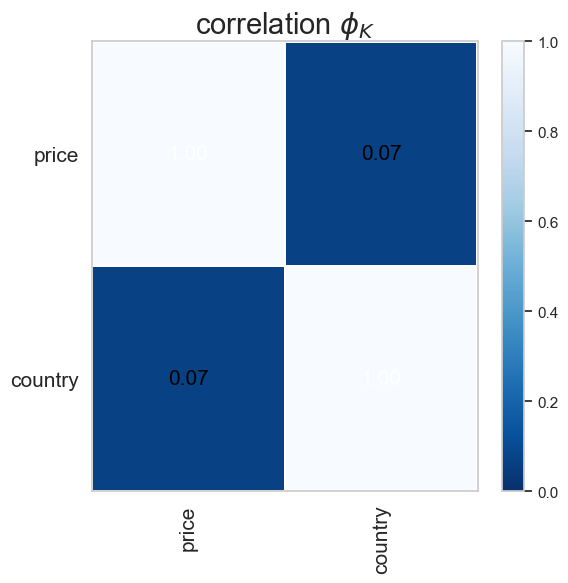

In [16]:
phik = phik_matrix(auto[['country', 'price']])
plot_correlation_matrix(phik.values, 
                        x_labels=phik.columns, 
                        y_labels=phik.index, 
                        vmin=0, vmax=1, color_map="Blues_r", 
                        title=r'correlation $\phi_K$', 
                        fontsize_factor=1.5, 
                        figsize=(6, 6))
plt.tight_layout()

Как видим корреляция имеется, но не значительная. Зависимости нелинейные. Сложно ожидать высоких корреляций. Оставляем датасет

# Вывод: 

Путем поиска релевантной информации и детального исследования, судя по всему наше приложение, предполагается разрабатываться в **Нидерландах** (единственная страна из ЕС в наших данных). 

# Посмотрим на средний прайс по странам:

In [17]:
nl = auto.pivot_table(values='price', index=['country'], aggfunc='median').sort_values(by='price', ascending=False)
geo = auto.loc[auto['country'] == 'NL']
print(nl)

           price
country         
UY      3,850.00
MX      2,999.00
UA      2,750.00
US      2,700.00
SG      2,650.00
MY      2,570.00
TR      2,399.00
NZ      2,300.00
ZA      2,249.50
NL      2,100.00
PE      2,100.00
NO      2,000.00
YT      1,895.00


Почему-то самый дорогостоящий прайс у нас в **Уругвае** скорее всего связано с высоким транспортным налогом, интересующая нас страна - **Нидерланды** по среднему чеку составляет примерно **2100** евро.

# В качестве доказательства, что индексы и адреса соответствуют действительности:

Загрузим библиотеку **Geopy** и найдем данные по координатам, и сравним с нашей таблицей:

In [18]:
geo.head(1)

,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,last_seen,country,city,n5,n6
postal_code,,,,,,,,,,,,,,,,,,
1067,2016-03-21 21:46:45,2238,small,2003,manual,75,corsa,125000,5,petrol,opel,no,2016-03-21,2016-03-24 11:46:38,NL,Amsterdam,52.38,4.80


По координатам **'52.38, 4.80'** мы должны найти **Нидерланды**, город **Амстердам**

In [19]:
geolocator = Nominatim(user_agent="my_train_project")
location = geolocator.reverse('52.38, 4.80')
print(pd.DataFrame(location))

                                                                                                 0
0  44, Teldershof, Geuzenveld, Nieuw-West, Amsterdam, Noord-Holland, Nederland, 1067 ML, Nederland
1                                                                          (52.3800448, 4.8000484)


# Как видим всё полностью совпадает, в том числе и индекс с нашего датасета **"1067"**

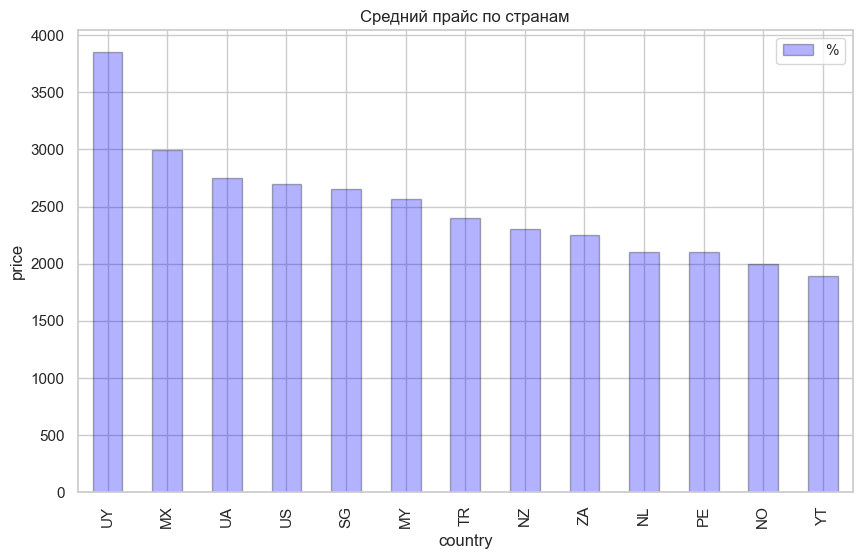

In [20]:
#посмотрим средний прайс по странам
nl.plot(kind='bar', ec='black', figsize=(10,6), alpha=0.3, color='blue')
plt.title('Средний прайс по странам')
plt.ylabel('price')
plt.legend('%')
plt.show();

In [21]:
auto.shape[0]


944749

In [22]:
information(auto, 'Все страны')

****************************** Все страны ******************************



,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,last_seen,country,city,n5,n6
postal_code,,,,,,,,,,,,,,,,,,
1067,2016-03-21 21:46:45,2238,small,2003,manual,75,corsa,125000,5,petrol,opel,no,2016-03-21,2016-03-24 11:46:38,NL,Amsterdam,52.38,4.80
1067,2016-03-21 21:46:45,2238,small,2003,manual,75,corsa,125000,5,petrol,opel,no,2016-03-21,2016-03-24 11:46:38,NO,Oslo,59.85,10.78
1067,2016-03-20 12:59:45,4000,NaN,2017,manual,0,2_reihe,150000,0,NaN,peugeot,yes,2016-03-20,2016-04-06 13:15:59,NL,Amsterdam,52.38,4.80


------------------------- INFO -------------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 944749 entries, 1067 to 99998
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        944749 non-null  datetime64[ns]
 1   price               944749 non-null  int64         
 2   vehicle_type        843294 non-null  object        
 3   registration_year   944749 non-null  int64         
 4   gear_box            892373 non-null  object        
 5   power               944749 non-null  int64         
 6   model               890434 non-null  object        
 7   kilometer           944749 non-null  int64         
 8   registration_month  944749 non-null  int64         
 9   fuel_type           858365 non-null  object        
 10  brand               944749 non-null  object        
 11  repaired            756203 non-null  object        
 12  date_created        944749

None


---------- NAN ----------



date_crawled               0
price                      0
vehicle_type          101455
registration_year          0
gear_box               52376
power                      0
model                  54315
kilometer                  0
registration_month         0
fuel_type              86384
brand                      0
repaired              188546
date_created               0
last_seen                  0
country                99321
city                   99321
n5                     99321
n6                     99321
dtype: int64

,0
repaired,20.000000
vehicle_type,10.700000
n6,10.500000
n5,10.500000
city,10.500000
country,10.500000
fuel_type,9.100000
model,5.700000
gear_box,5.500000
kilometer,0.000000



----- DESCRIBE -----


,price,registration_year,power,kilometer,registration_month,n5,n6
count,"944,749.00","944,749.00","944,749.00","944,749.00","944,749.00","845,428.00","845,428.00"
mean,"4,395.07","2,003.61",109.79,"127,853.63",5.70,25.84,-52.83
std,"4,524.70",66.79,169.18,"38,066.71",3.74,20.46,61.43
min,0.00,"1,000.00",0.00,"5,000.00",0.00,-46.20,-168.87
25%,"1,000.00","1,999.00",69.00,"125,000.00",3.00,19.33,-99.61
50%,"2,650.00","2,003.00",103.00,"150,000.00",6.00,27.17,-81.15
75%,"6,450.00","2,008.00",141.00,"150,000.00",9.00,40.26,26.55
max,"20,000.00","9,999.00","20,000.00","150,000.00",12.00,70.66,177.50



----- DUPLICATED -----


0


------------------------- UNIQUE VALUES -------------------------


'date_crawled'

271174

+++++++++++++++++++++++++


'price'

3731

+++++++++++++++++++++++++


'vehicle_type'

9

+++++++++++++++++++++++++


'registration_year'

151

+++++++++++++++++++++++++


'gear_box'

3

+++++++++++++++++++++++++


'power'

712

+++++++++++++++++++++++++


'model'

251

+++++++++++++++++++++++++


'kilometer'

13

+++++++++++++++++++++++++


'registration_month'

13

+++++++++++++++++++++++++


'fuel_type'

8

+++++++++++++++++++++++++


'brand'

40

+++++++++++++++++++++++++


'repaired'

3

+++++++++++++++++++++++++


'date_created'

109

+++++++++++++++++++++++++


'last_seen'

179150

+++++++++++++++++++++++++


'country'

14

+++++++++++++++++++++++++


'city'

16761

+++++++++++++++++++++++++


'n5'

14071

+++++++++++++++++++++++++


'n6'

14212

+++++++++++++++++++++++++
----------------------------------------------------------------------------------------------------


In [23]:

visual = auto[['country','n5', 'n6']]
visual = visual.drop_duplicates (subset=['country'])
visual = visual.reset_index(drop=True)
display(visual.head(5))
visual.columns = ['country', 'latitude', 'longitude']
visual = visual.dropna()
m = folium.Map(location=[visual['latitude'].mean(), visual['longitude'].mean()], zoom_start=1)

for index, row in visual.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']], popup=row['country']).add_to(m)





,country,n5,n6
0,NL,52.38,4.80
1,NO,59.85,10.78
2,US,42.35,-72.05
3,ZA,-25.78,29.47
4,NaN,NaN,NaN


# **Поcмотрим на интерактивную карту визуализации стран в нашем датасете через Folium**

In [24]:
m

In [25]:
#посмотрим на количество уникальных значений городов
display(auto['city'].unique())
len(auto['city'].unique())

array(['Amsterdam', 'Oslo', 'Oakham', ..., 'Jesús Maria', 'Palmarejo',
       'San Jose de Palmarejo'], dtype=object)

16761

In [26]:
#Уникальные значения по моделям
display(auto['model'].unique())
len(auto['model'].unique())

array(['corsa', '2_reihe', 'golf', 'e_klasse', '3er', 'polo', 'c_klasse',
       'passat', 'touareg', '5er', 'a3', '6er', 's_klasse', 'transporter',
       'other', '3_reihe', 'forester', 'mondeo', 'caddy', 'sharan',
       'touran', 'viano', 'astra', 'a4', 'xc_reihe', nan, 'vectra', 'a6',
       'insignia', '7er', 'micra', 'avensis', 'vito', 'tiguan', 'vivaro',
       'rio', 'octavia', 'twingo', 'focus', 'tt', 'a_klasse', 'fiesta',
       'zafira', 'primera', 'corolla', 'yaris', 'v40', '80', 'clio',
       'megane', 'a2', 'kadett', 'almera', 'fusion', 'crossfire', 'a8',
       'mx_reihe', 'ceed', 'x_trail', 'v70', 'civic', 'swift', 'cooper',
       'fabia', '6_reihe', 'lancer', 'leon', 'kaefer', 'cordoba',
       'scirocco', 'logan', 'fortwo', 'b_klasse', 'omega', 'jazz',
       'laguna', 'lupo', 'accord', '147', 'ibiza', 'g_klasse', '4_reihe',
       'ka', 'yeti', '1_reihe', 'jetta', 'superb', 'range_rover',
       'm_klasse', '601', 'scenic', 'toledo', 'eos', 'bora', '100', '1er',
 

251

In [27]:
auto.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year',
       'gear_box', 'power', 'model', 'kilometer', 'registration_month',
       'fuel_type', 'brand', 'repaired', 'date_created', 'last_seen',
       'country', 'city', 'n5', 'n6'],
      dtype='object')

In [28]:
auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 944749 entries, 1067 to 99998
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        944749 non-null  datetime64[ns]
 1   price               944749 non-null  int64         
 2   vehicle_type        843294 non-null  object        
 3   registration_year   944749 non-null  int64         
 4   gear_box            892373 non-null  object        
 5   power               944749 non-null  int64         
 6   model               890434 non-null  object        
 7   kilometer           944749 non-null  int64         
 8   registration_month  944749 non-null  int64         
 9   fuel_type           858365 non-null  object        
 10  brand               944749 non-null  object        
 11  repaired            756203 non-null  object        
 12  date_created        944749 non-null  datetime64[ns]
 13  last_seen           944749 

In [29]:
#Подготовим категориальные признаки
cat = list(auto.select_dtypes(include='object').columns)
cat

['vehicle_type',
 'gear_box',
 'model',
 'fuel_type',
 'brand',
 'repaired',
 'country',
 'city']

In [30]:
#Подготовим непрерывные признаки
num = list(auto.select_dtypes(include='int64').columns)
num

['price', 'registration_year', 'power', 'kilometer', 'registration_month']

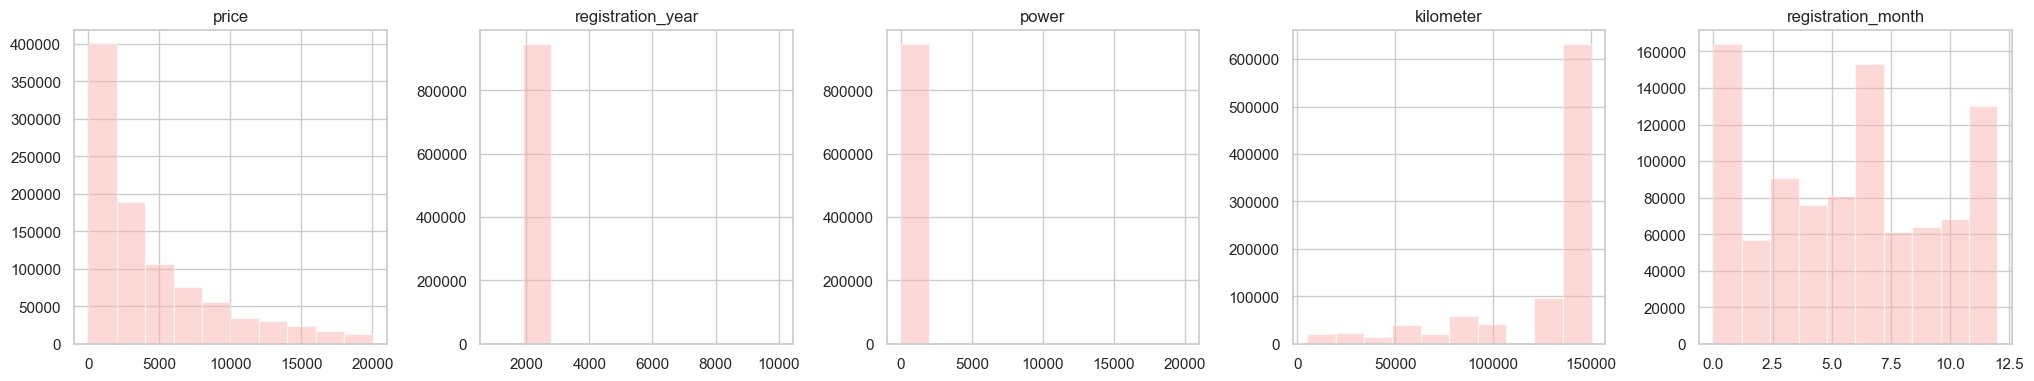

In [31]:
#Посмотрим детально на гисторграмму непрерывных признаков
auto[num].hist(layout=(4,5),figsize=(25, 20),alpha=0.5);

**Ящики с усами**

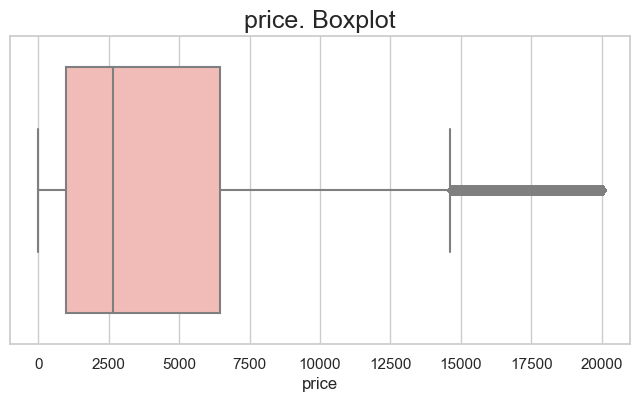

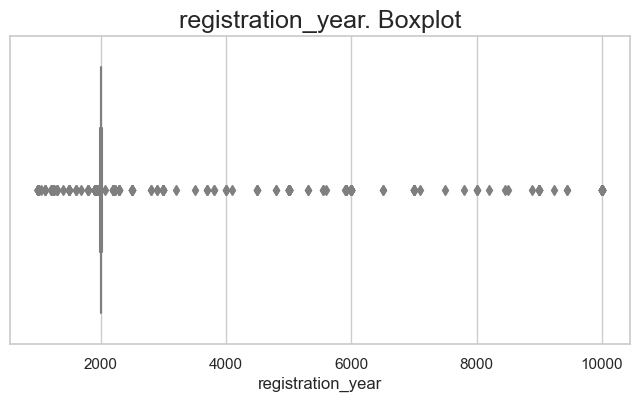

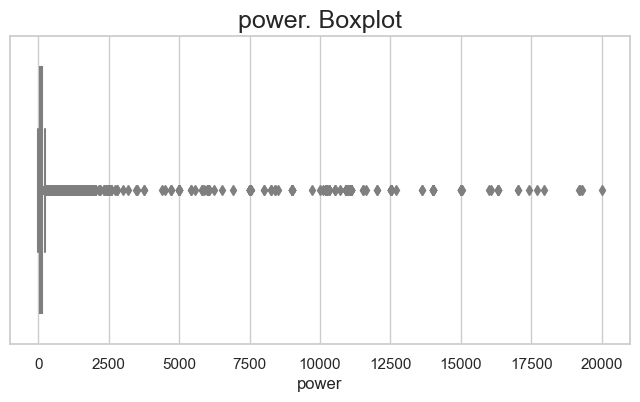

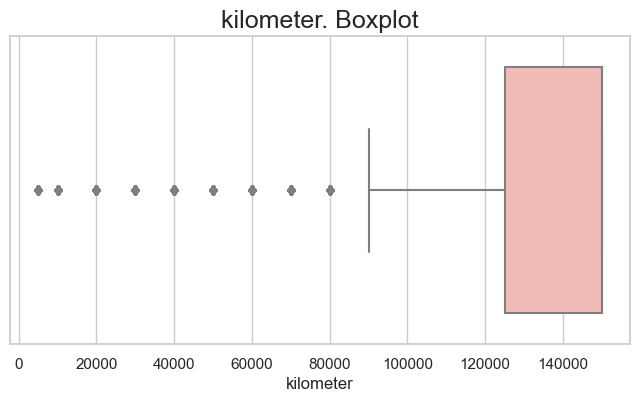

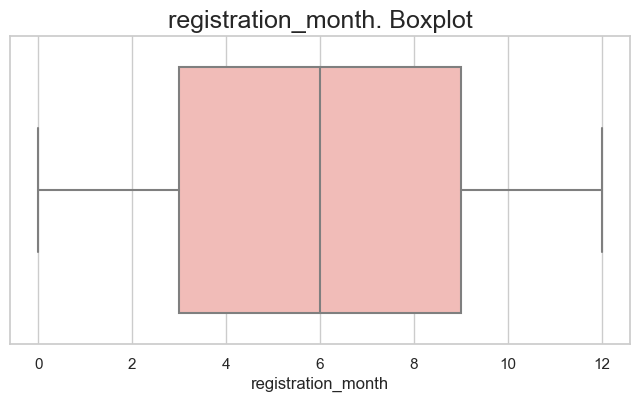

In [32]:
for column in num:
    f, axes = plt.subplots(figsize=(8, 4))
    axes.set_title(column + ". Boxplot", fontsize=18)
    sns.boxplot(auto[column], x=column);


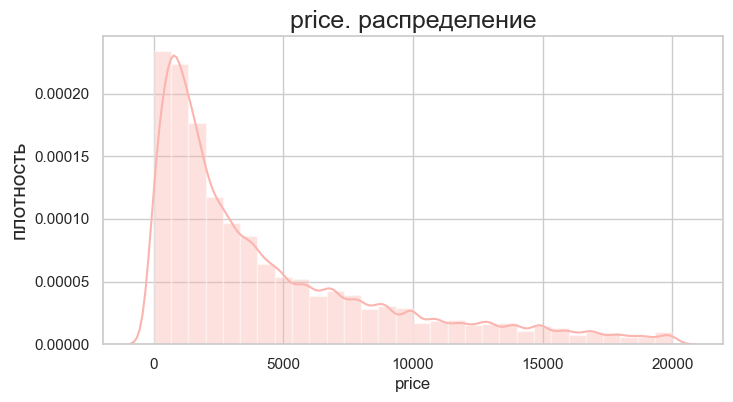

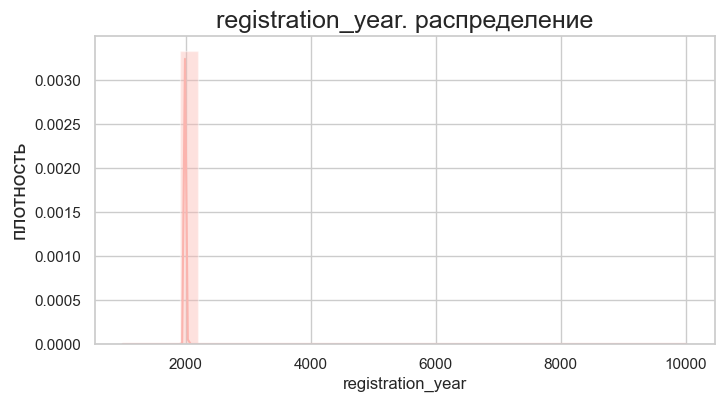

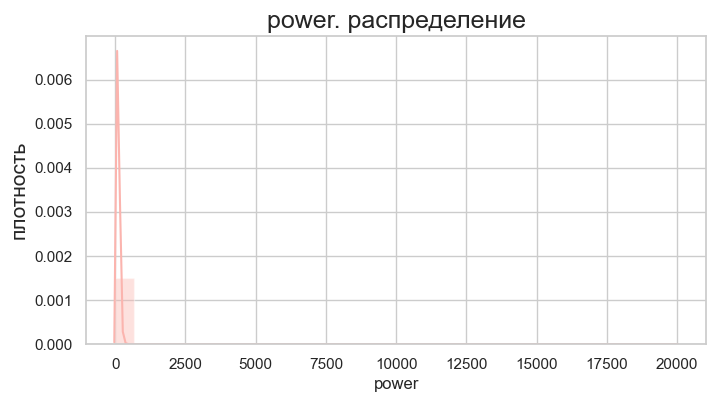

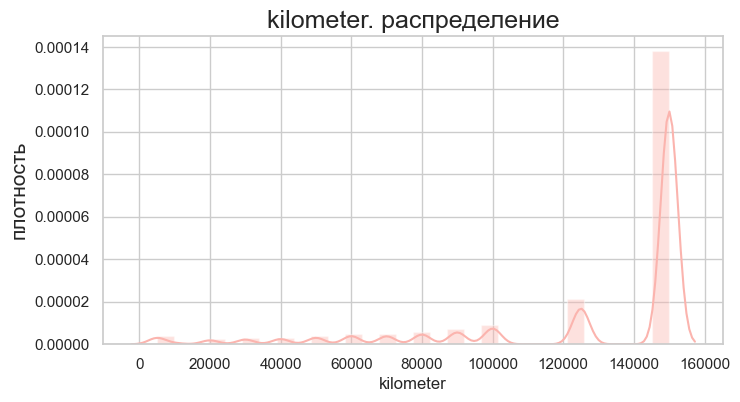

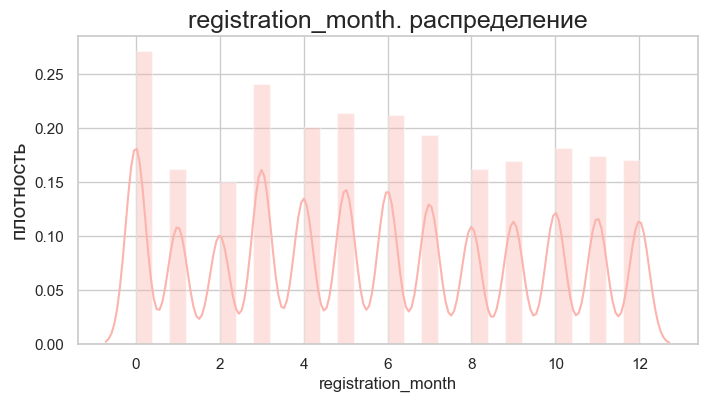

In [33]:
for column in num:
    f, axes = plt.subplots(figsize=(8, 4))
    plt.title(column + ". распределение", fontsize=18)
    plt.ylabel('плотность', fontsize=15)
    sns.distplot(auto[column], bins=30, rug=False);

# Начнем по порядку обрабатывать признаки, которые показали нам отклонения в гистограммах

# **Начнем с ценового диапозона  price**

In [34]:
auto['price'].quantile([0.0, 0.01, 0.02,0.05, 0.1, .5, .65, .75, .85, .93, .99]).transpose()

0.00        0.00
0.01        0.00
0.02        0.00
0.05      150.00
0.10      450.00
0.50    2,650.00
0.65    4,490.00
0.75    6,450.00
0.85    9,000.00
0.93   13,000.00
0.99   18,799.00
Name: price, dtype: float64

In [35]:
#Цены ниже 100 евро есть смысл обрезать, так как в металлолом сдать будет проще за эту сумму
auto = auto.loc[auto['price'] >= 100]

In [36]:
auto['price'].describe().to_frame().transpose()

,count,mean,std,min,25%,50%,75%,max
price,"906,340.00","4,581.12","4,526.48",100.00,"1,200.00","2,899.00","6,600.00","20,000.00"


# **Год регистрации registration_year**

In [37]:
auto['registration_year'].quantile([0.0,0.025,0.05, 0.1, .5, .65, .75, .85, .97, .99]).transpose()

0.00   1,000.00
0.03   1,988.00
0.05   1,992.00
0.10   1,995.00
0.50   2,003.00
0.65   2,006.00
0.75   2,008.00
0.85   2,010.00
0.97   2,017.00
0.99   2,018.00
Name: registration_year, dtype: float64

In [38]:
#Посмотриим сколько дней было скачивание анкет
auto['date_crawled'].max() - auto['date_crawled'].min()

Timedelta('33 days 00:30:36')

In [39]:
#Какие месяца
display(auto['date_crawled'].min())
display(auto['date_crawled'].max())

Timestamp('2016-03-05 14:06:22')

Timestamp('2016-04-07 14:36:58')

In [40]:
#Даты до 1988 года есть смысл обрезать, так как по квантилям видим выброс
#На этапе обзора данных видно, что дата скачивания у нас 2016г, значит год регистрации выше нужно удалить
auto.reset_index(inplace=True)
auto = auto.loc[auto['registration_year'] >= 1988] 
auto = auto.loc[auto['registration_year'] <= 2016]

# **Мощность(л.с) power**

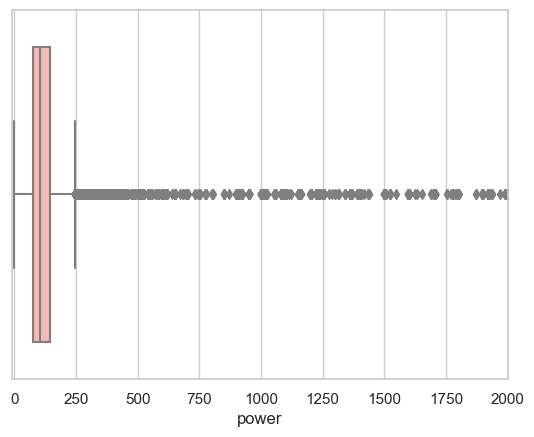

In [41]:
sns.boxplot(auto['power'])
plt.xlim(-10, 2000);

In [42]:
auto['power'].quantile([0.0,0.025,0.05, 0.1, .5, .65, .75, .85, .975, .99, 1]).transpose()

0.00        0.00
0.03        0.00
0.05        0.00
0.10       45.00
0.50      105.00
0.65      128.00
0.75      143.00
0.85      170.00
0.97      250.00
0.99      306.00
1.00   20,000.00
Name: power, dtype: float64

**Ниже просмотрим на информацию из [Википедии](https://en.wikipedia.org/wiki/List_of_production_cars_by_power_output)**

In [43]:
url = 'https://en.wikipedia.org/wiki/List_of_production_cars_by_power_output'
year_p = pd.read_html(url)[2]
year_p['Year'] = year_p['Year'].apply(lambda year_str: int(year_str[:4]))
year_p[(year_p['Year'] >= 1988) & (year_p['Year'] <= 2016)]

,Vehicle,Year,Power,Notes,Sources
16,Bugatti EB110,1991,412 kW (553 hp; 560 PS),139 produced.,[67]
17,McLaren F1,1992,461 kW (618 hp; 627 PS),106 produced. Remained most powerful car for 12 years (including the LM).,[68]
18,McLaren F1 LM,1995,500 kW (671 hp; 680 PS),6 produced including the prototype.,[69][70]
19,Koenigsegg CCR,2004,601 kW (806 hp; 817 PS),14 produced.,[48][49]
20,Bugatti Veyron,2005,"736 kW (987 hp; 1,001 PS)",310 produced (16.4 and Grand Sport). First car with a double-clutch transmission on list.,[71][25]
21,SSC Ultimate Aero TT,2009,"960 kW (1,287 hp; 1,305 PS)",Last car with a manual transmission on list.,[72]
22,Koenigsegg One:1,2014,"1,000 kW (1,341 hp; 1,360 PS)",7 produced.,[73]
23,Koenigsegg Regera,2016,"1,119 kW (1,500 hp; 1,521 PS)",80 units produced. First hybrid car on list.,[74]


Как видим тут в основном авто с типом кузова купе(Coupe) посмотрим на наши данные:

In [44]:
see = pd.DataFrame(auto.loc[auto['power'] >=500]['vehicle_type'])
display(see['vehicle_type'].unique())

array(['wagon', 'sedan', 'small', nan, 'bus', 'coupe', 'convertible',
       'suv', 'other'], dtype=object)

In [45]:
auto.loc[auto['vehicle_type'] == 'coupe']['power'].quantile([0.0,0.025,0.05, 0.1, .5, .65, .75, .85, .975, .99, 1]).transpose()

0.00        0.00
0.03        0.00
0.05        0.00
0.10       71.00
0.50      150.00
0.65      170.00
0.75      193.00
0.85      224.00
0.97      306.00
0.99      343.00
1.00   20,000.00
Name: power, dtype: float64

In [46]:
auto.loc[auto['power'] >= 350]

,postal_code,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,last_seen,country,city,n5,n6
270,1069,2016-03-07 09:53:11,13750,wagon,2006,auto,520,a6,80000,11,petrol,audi,yes,2016-03-07,2016-04-02 13:17:23,NL,Amsterdam,52.36,4.79
271,1069,2016-03-07 09:53:11,13750,wagon,2006,auto,520,a6,80000,11,petrol,audi,yes,2016-03-07,2016-04-02 13:17:23,NO,Oslo,59.85,10.78
272,1069,2016-03-07 09:53:11,13750,wagon,2006,auto,520,a6,80000,11,petrol,audi,yes,2016-03-07,2016-04-02 13:17:23,US,Palmer,42.18,-72.33
273,1069,2016-03-07 09:53:11,13750,wagon,2006,auto,520,a6,80000,11,petrol,audi,yes,2016-03-07,2016-04-02 13:17:23,ZA,Middelburg,-25.78,29.47
494,1099,2016-03-19 09:39:50,16999,sedan,2006,auto,515,a8,150000,6,petrol,audi,no,2016-03-19,2016-03-22 16:50:56,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
904222,99734,2016-03-07 12:53:51,2885,convertible,2009,manual,702,500,50000,8,petrol,fiat,yes,2016-03-07,2016-03-07 17:19:43,US,Prudhoe Bay,70.29,-148.67
904798,99755,2016-03-07 23:43:31,3999,sedan,2008,auto,450,other,150000,6,petrol,audi,no,2016-03-07,2016-03-15 04:15:17,MX,Ojuelos,21.65,-103.25
904799,99755,2016-03-07 23:43:31,3999,sedan,2008,auto,450,other,150000,6,petrol,audi,no,2016-03-07,2016-03-15 04:15:17,SG,Bukit Teresa Road,1.28,103.83
904800,99755,2016-03-07 23:43:31,3999,sedan,2008,auto,450,other,150000,6,petrol,audi,no,2016-03-07,2016-03-15 04:15:17,US,Denali National Park,63.54,-149.99


**Тип кузова 'convertible' тоже самое что и 'coupe'**

Модели конечно же у нас другие, но хотя бы понятно какой сегмент из люксовых у нас преобладает и какова их мощность. Сохраним тренд для модели не будем сильно обрубать выбросы в мощности. Если посмотреть по таблице, то из реально люксовых с более менее свежим выпуском авто действительно есть мощности до 500 л.с обрежем по этому диапозону. Плюс по боксплоту видно что примерно от 500 частота значений уменьшается.

In [47]:
auto = auto.loc[auto['power'] <= 500] 

# **Пробег kilometer**

In [48]:
auto['kilometer'].quantile([0.0,0.02,0.05, 0.1, .5, .65, .75, .85, .93, .975, .99]).transpose()

0.00     5,000.00
0.02    20,000.00
0.05    40,000.00
0.10    70,000.00
0.50   150,000.00
0.65   150,000.00
0.75   150,000.00
0.85   150,000.00
0.93   150,000.00
0.97   150,000.00
0.99   150,000.00
Name: kilometer, dtype: float64

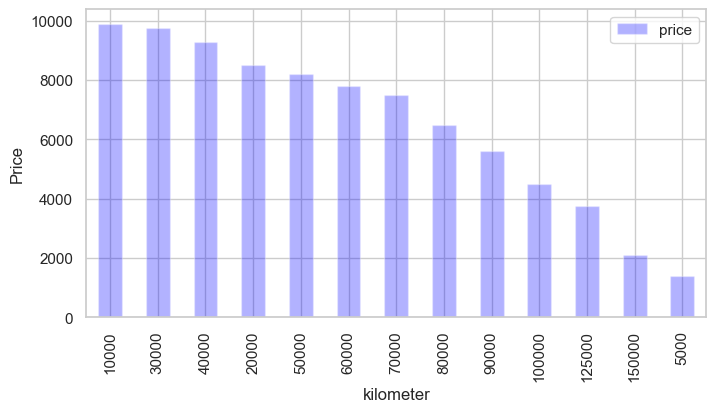

In [49]:
auto.pivot_table(index='kilometer', values='price', aggfunc='median').sort_values(by='price',
                                                                                    ascending=False).plot(kind='bar',
                                                                                     alpha=0.3, color='blue',figsize=(8,4))
plt.ylabel('Price');

In [50]:
auto.loc[auto['kilometer'] == 5000]

,postal_code,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,last_seen,country,city,n5,n6
234,1069,2016-03-16 11:38:45,2100,sedan,2005,NaN,101,passat,5000,0,gasoline,volkswagen,no,2016-03-16,2016-03-17 08:46:34,NL,Amsterdam,52.36,4.79
235,1069,2016-03-16 11:38:45,2100,sedan,2005,NaN,101,passat,5000,0,gasoline,volkswagen,no,2016-03-16,2016-03-17 08:46:34,NO,Oslo,59.85,10.78
236,1069,2016-03-16 11:38:45,2100,sedan,2005,NaN,101,passat,5000,0,gasoline,volkswagen,no,2016-03-16,2016-03-17 08:46:34,US,Palmer,42.18,-72.33
237,1069,2016-03-16 11:38:45,2100,sedan,2005,NaN,101,passat,5000,0,gasoline,volkswagen,no,2016-03-16,2016-03-17 08:46:34,ZA,Middelburg,-25.78,29.47
258,1069,2016-03-15 18:47:41,2200,sedan,2005,manual,101,passat,5000,0,gasoline,volkswagen,NaN,2016-03-15,2016-03-15 18:47:41,NL,Amsterdam,52.36,4.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905625,99869,2016-03-24 13:38:40,18350,sedan,2014,manual,120,other,5000,7,petrol,suzuki,no,2016-03-24,2016-04-07 04:45:22,NaN,NaN,NaN,NaN
906124,99974,2016-03-26 14:52:21,4250,NaN,2000,manual,170,3er,5000,2,petrol,bmw,no,2016-03-26,2016-04-06 02:46:27,MX,El Ranchito,21.40,-103.08
906316,99998,2016-03-20 22:42:45,740,wagon,1998,manual,136,omega,5000,0,petrol,opel,no,2016-03-20,2016-04-07 07:46:32,MX,Jesús Maria,21.10,-103.16
906317,99998,2016-03-20 22:42:45,740,wagon,1998,manual,136,omega,5000,0,petrol,opel,no,2016-03-20,2016-04-07 07:46:32,MX,Palmarejo,21.10,-103.13


Здесь не будем обрезать значения, скорее всего они важны в понимании составления прайса.

In [51]:
auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 848331 entries, 0 to 906339
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   postal_code         848331 non-null  int64         
 1   date_crawled        848331 non-null  datetime64[ns]
 2   price               848331 non-null  int64         
 3   vehicle_type        798303 non-null  object        
 4   registration_year   848331 non-null  int64         
 5   gear_box            811922 non-null  object        
 6   power               848331 non-null  int64         
 7   model               810780 non-null  object        
 8   kilometer           848331 non-null  int64         
 9   registration_month  848331 non-null  int64         
 10  fuel_type           791474 non-null  object        
 11  brand               848331 non-null  object        
 12  repaired            700287 non-null  object        
 13  date_created        848331 no

In [52]:
#создадим новый признак-срок эксплуатации авто(в годах), зная дату регистрации и дату создания анкеты
auto['life_span'] = pd.DatetimeIndex(auto['date_created']).year - auto['registration_year']
auto['life_span'].isna().sum()
auto['life_span']

0         13
1         13
4         13
5         13
6          9
          ..
906335     8
906336     8
906337     9
906338     9
906339     9
Name: life_span, Length: 848331, dtype: int64

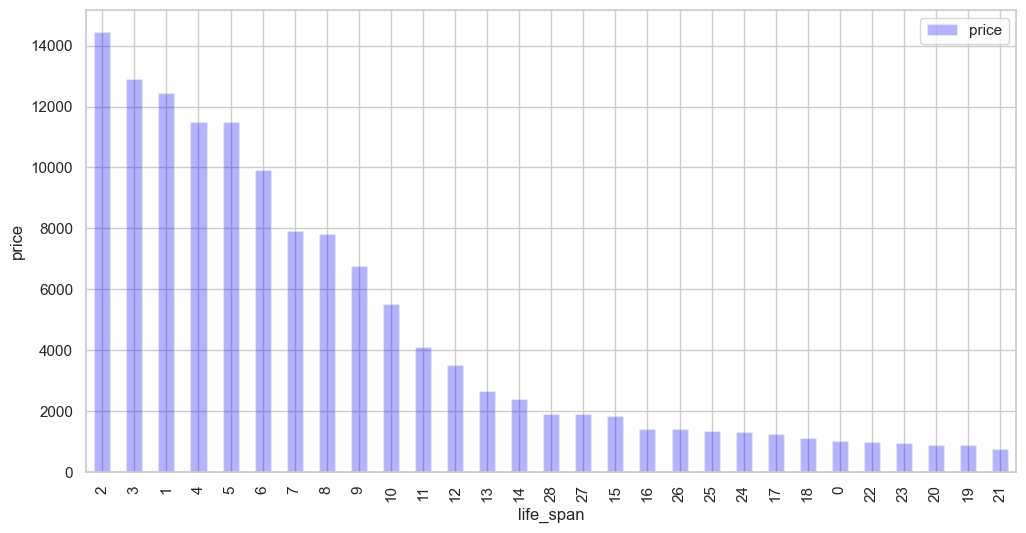

In [53]:

auto.pivot_table(index='life_span', values='price', aggfunc='median').sort_values(by='price', ascending=False).plot(kind='bar',
                                                                                                     alpha=0.3,
                                                                                                     color='blue',
                                                                                                     figsize=(12,6))
plt.ylabel('price');

Как видим корреляция с прайсом есть, обратно пропорциональная.

In [54]:
auto.sample(3)

,postal_code,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,last_seen,country,city,n5,n6,life_span
538799,58300,2016-03-21 12:52:50,3300,sedan,2003,manual,122,c_klasse,150000,7,gasoline,mercedes_benz,no,2016-03-21,2016-04-02 10:16:40,MX,Ampliación La Nueva Aldea,19.72,-101.13,13
833772,87724,2016-03-18 13:38:46,700,sedan,1998,manual,150,3er,150000,0,petrol,bmw,NaN,2016-03-18,2016-03-18 13:38:46,US,La Loma,35.17,-105.08,18
432879,49610,2016-03-27 13:44:09,999,small,1995,manual,45,corsa,150000,2,petrol,opel,no,2016-03-27,2016-04-07 09:16:24,US,Acme,44.79,-85.49,21


Создадим новый признак **duration** продолжительность нахождения анкеты на сайте(в днях), если считать последнее посещение за крайнюю дату. По нему мы будем ориентироваться какие объявления стоит удалить, так как они задержались на сайте слишком долго, значит стоимость была выставлена не актуально. Затем этот признак будет удален, чтобы не допустить переобучения модели, и утечки данных в таргет,так как до начала процесса, модели будет неизвестна продолжительность.

In [55]:
auto['duration'] = pd.DatetimeIndex(auto['last_seen']) - pd.DatetimeIndex(auto['date_created'])
auto['duration'] = auto['duration'].dt.days
auto['duration']

0          3
1          3
4          0
5          0
6          3
          ..
906335    30
906336    30
906337     1
906338     1
906339     1
Name: duration, Length: 848331, dtype: int64

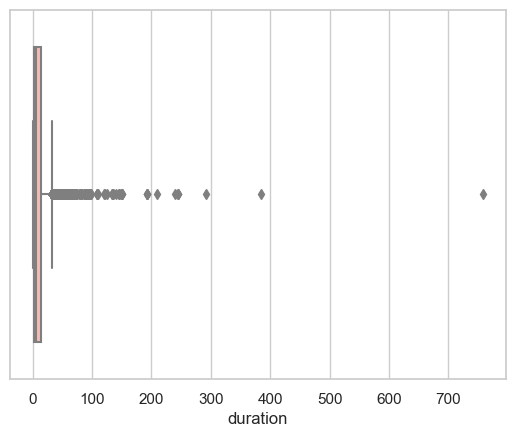

In [56]:
sns.boxplot(auto['duration']);

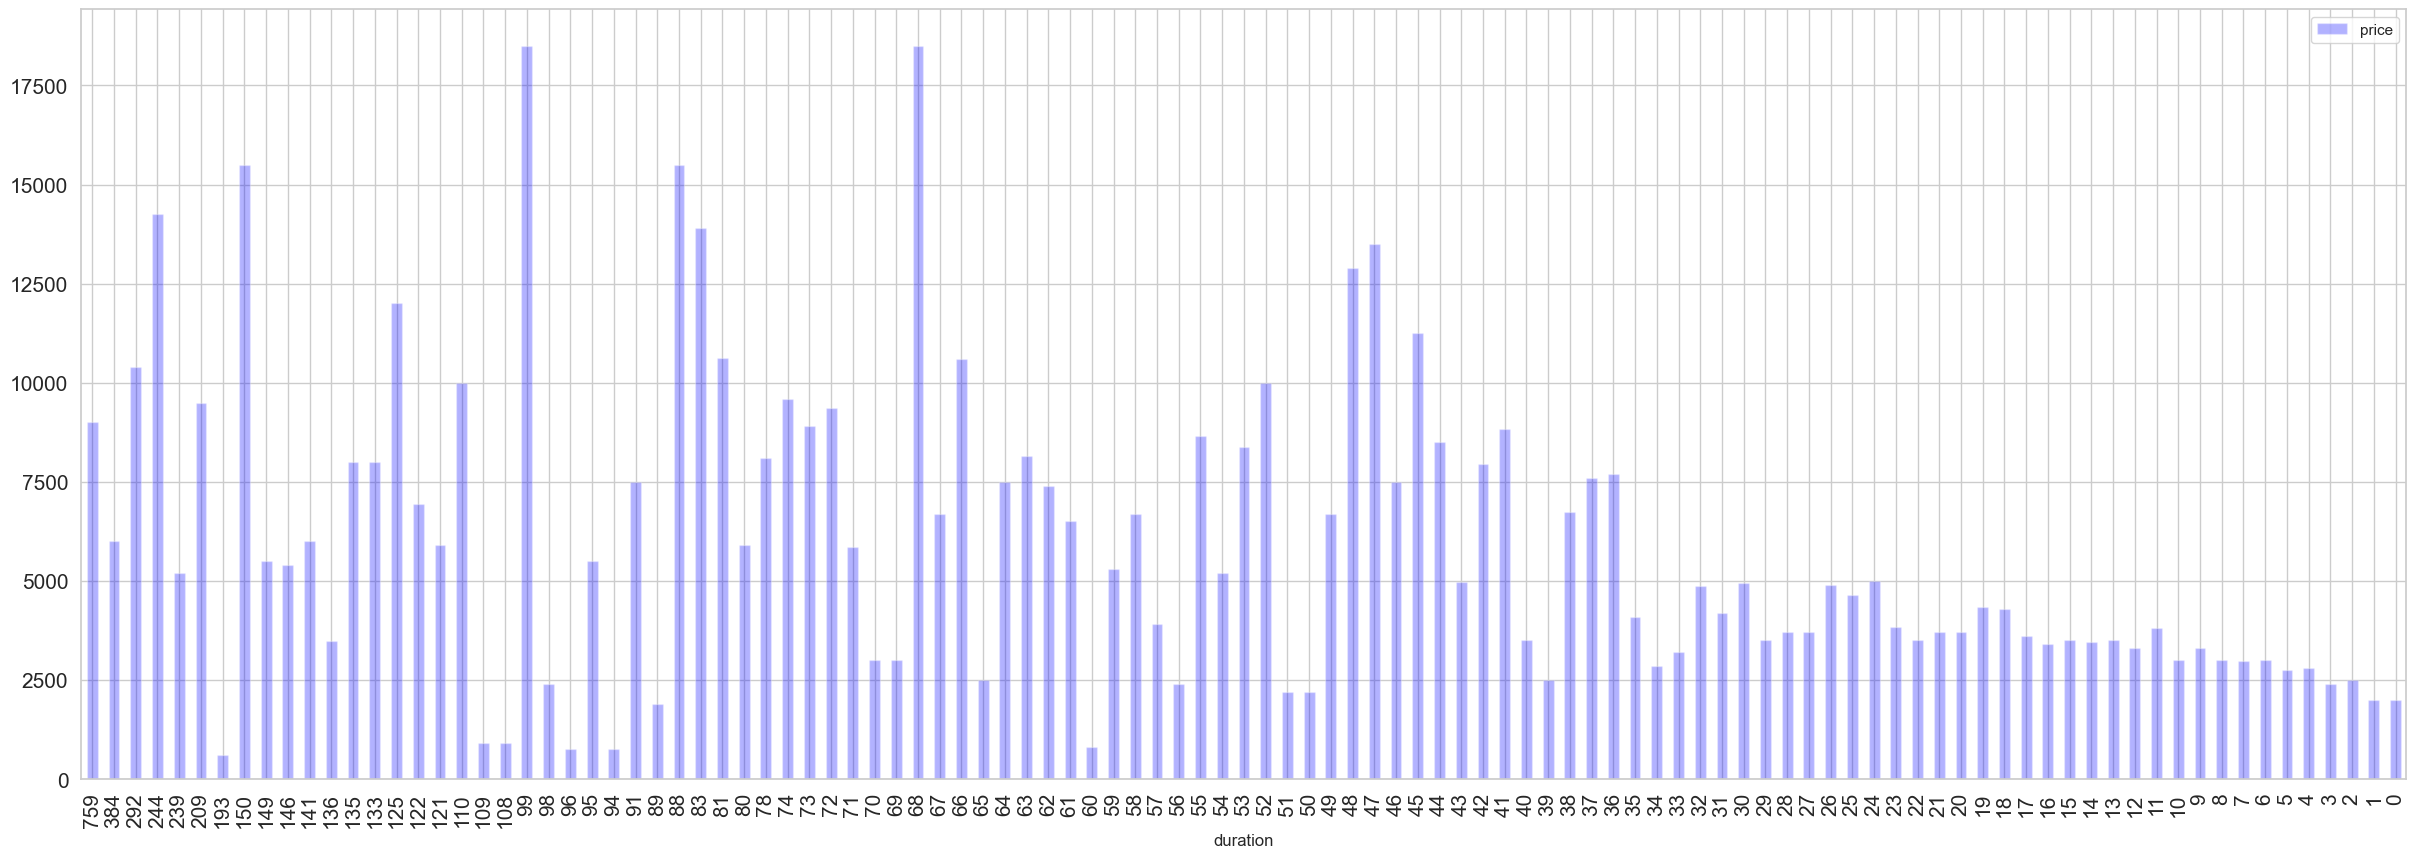

In [57]:
auto.pivot_table(index='duration', values='price', aggfunc='median').sort_values(by='duration',
                                                                                    ascending=False).plot(kind='bar',
                                                                                    alpha=0.3,
                                                                                    color='blue',
                                                                                    figsize=(30,10),
                                                                                    fontsize=15);

In [58]:
auto['duration'].quantile([0.0,0.025,0.05, 0.1, .5, .65, .75, .85, .93, .975 , .99, 1.]).transpose()

0.00     0.00
0.03     0.00
0.05     0.00
0.10     0.00
0.50     6.00
0.65    10.00
0.75    14.00
0.85    19.00
0.93    25.00
0.97    29.00
0.99    31.00
1.00   759.00
Name: duration, dtype: float64

Так как средний прайс у нас примерно 4000 евро, удалим все объявления которые висели дольше 35 дней, так как далее по графику видим, что скорее цена была очень завышена, поэтому объявление долго висело на сайте.

In [59]:
auto = auto.loc[auto['duration'] <= 35]

In [60]:
auto.shape[0]

847705

In [61]:
information(auto, 'all countries')

****************************** all countries ******************************



,postal_code,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,...,brand,repaired,date_created,last_seen,country,city,n5,n6,life_span,duration
0,1067,2016-03-21 21:46:45,2238,small,2003,manual,75,corsa,125000,5,...,opel,no,2016-03-21,2016-03-24 11:46:38,NL,Amsterdam,52.38,4.80,13,3
1,1067,2016-03-21 21:46:45,2238,small,2003,manual,75,corsa,125000,5,...,opel,no,2016-03-21,2016-03-24 11:46:38,NO,Oslo,59.85,10.78,13,3
4,1067,2016-03-16 19:58:08,1900,sedan,2003,manual,0,golf,150000,8,...,volkswagen,NaN,2016-03-16,2016-03-16 19:58:08,NL,Amsterdam,52.38,4.80,13,0


------------------------- INFO -------------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 847705 entries, 0 to 906339
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   postal_code         847705 non-null  int64         
 1   date_crawled        847705 non-null  datetime64[ns]
 2   price               847705 non-null  int64         
 3   vehicle_type        797712 non-null  object        
 4   registration_year   847705 non-null  int64         
 5   gear_box            811303 non-null  object        
 6   power               847705 non-null  int64         
 7   model               810182 non-null  object        
 8   kilometer           847705 non-null  int64         
 9   registration_month  847705 non-null  int64         
 10  fuel_type           790877 non-null  object        
 11  brand               847705 non-null  object        
 12  repaired            699737 n

None


---------- NAN ----------



postal_code                0
date_crawled               0
price                      0
vehicle_type           49993
registration_year          0
gear_box               36402
power                      0
model                  37523
kilometer                  0
registration_month         0
fuel_type              56828
brand                      0
repaired              147968
date_created               0
last_seen                  0
country                89578
city                   89578
n5                     89578
n6                     89578
life_span                  0
duration                   0
dtype: int64

,0
repaired,17.500000
n6,10.600000
n5,10.600000
city,10.600000
country,10.600000
fuel_type,6.700000
vehicle_type,5.900000
model,4.400000
gear_box,4.300000
life_span,0.000000



----- DESCRIBE -----


,postal_code,price,registration_year,power,kilometer,registration_month,n5,n6,life_span,duration
count,"847,705.00","847,705.00","847,705.00","847,705.00","847,705.00","847,705.00","758,127.00","758,127.00","847,705.00","847,705.00"
mean,"49,763.24","4,594.93","2,003.02",109.99,"128,611.60",5.86,26.06,-53.18,12.98,8.80
std,"27,343.86","4,538.76",5.76,61.45,"36,727.94",3.67,20.22,61.47,5.76,8.38
min,"1,067.00",100.00,"1,988.00",0.00,"5,000.00",0.00,-46.20,-168.87,0.00,0.00
25%,"25,840.00","1,200.00","1,999.00",75.00,"125,000.00",3.00,19.37,-99.68,9.00,2.00
50%,"51,570.00","2,900.00","2,003.00",105.00,"150,000.00",6.00,27.21,-81.92,13.00,6.00
75%,"71,397.00","6,700.00","2,007.00",143.00,"150,000.00",9.00,40.29,26.49,17.00,14.00
max,"99,998.00","20,000.00","2,016.00",500.00,"150,000.00",12.00,70.66,177.50,28.00,35.00



----- DUPLICATED -----


0


------------------------- UNIQUE VALUES -------------------------


'postal_code'

8129

+++++++++++++++++++++++++


'date_crawled'

251469

+++++++++++++++++++++++++


'price'

3598

+++++++++++++++++++++++++


'vehicle_type'

9

+++++++++++++++++++++++++


'registration_year'

29

+++++++++++++++++++++++++


'gear_box'

3

+++++++++++++++++++++++++


'power'

407

+++++++++++++++++++++++++


'model'

248

+++++++++++++++++++++++++


'kilometer'

13

+++++++++++++++++++++++++


'registration_month'

13

+++++++++++++++++++++++++


'fuel_type'

8

+++++++++++++++++++++++++


'brand'

40

+++++++++++++++++++++++++


'repaired'

3

+++++++++++++++++++++++++


'date_created'

59

+++++++++++++++++++++++++


'last_seen'

165672

+++++++++++++++++++++++++


'country'

14

+++++++++++++++++++++++++


'city'

16672

+++++++++++++++++++++++++


'n5'

14035

+++++++++++++++++++++++++


'n6'

14172

+++++++++++++++++++++++++


'life_span'

29

+++++++++++++++++++++++++


'duration'

36

+++++++++++++++++++++++++
----------------------------------------------------------------------------------------------------


In [62]:
auto = auto.dropna (subset=['country'])

In [63]:
auto = auto.reset_index(drop=True)
auto.head(5)

,postal_code,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,...,brand,repaired,date_created,last_seen,country,city,n5,n6,life_span,duration
0,1067,2016-03-21 21:46:45,2238,small,2003,manual,75,corsa,125000,5,...,opel,no,2016-03-21,2016-03-24 11:46:38,NL,Amsterdam,52.38,4.80,13,3
1,1067,2016-03-21 21:46:45,2238,small,2003,manual,75,corsa,125000,5,...,opel,no,2016-03-21,2016-03-24 11:46:38,NO,Oslo,59.85,10.78,13,3
2,1067,2016-03-16 19:58:08,1900,sedan,2003,manual,0,golf,150000,8,...,volkswagen,NaN,2016-03-16,2016-03-16 19:58:08,NL,Amsterdam,52.38,4.80,13,0
3,1067,2016-03-16 19:58:08,1900,sedan,2003,manual,0,golf,150000,8,...,volkswagen,NaN,2016-03-16,2016-03-16 19:58:08,NO,Oslo,59.85,10.78,13,0
4,1067,2016-04-04 23:48:00,12500,wagon,2007,manual,170,e_klasse,150000,11,...,mercedes_benz,no,2016-04-04,2016-04-07 04:16:54,NL,Amsterdam,52.38,4.80,9,3


Удаляем лишние признаки

In [64]:
auto = auto.drop(['postal_code', 'date_crawled', 'registration_year',
                       'registration_month', 'date_created', 'last_seen', 'n5', 'n6', 'duration'], axis=1).reset_index(drop=True)

In [65]:
auto.columns

Index(['price', 'vehicle_type', 'gear_box', 'power', 'model', 'kilometer',
       'fuel_type', 'brand', 'repaired', 'country', 'city', 'life_span'],
      dtype='object')

Напоследок смотрим корреляцию категориальных признаков

interval columns not set, guessing: ['price', 'life_span']


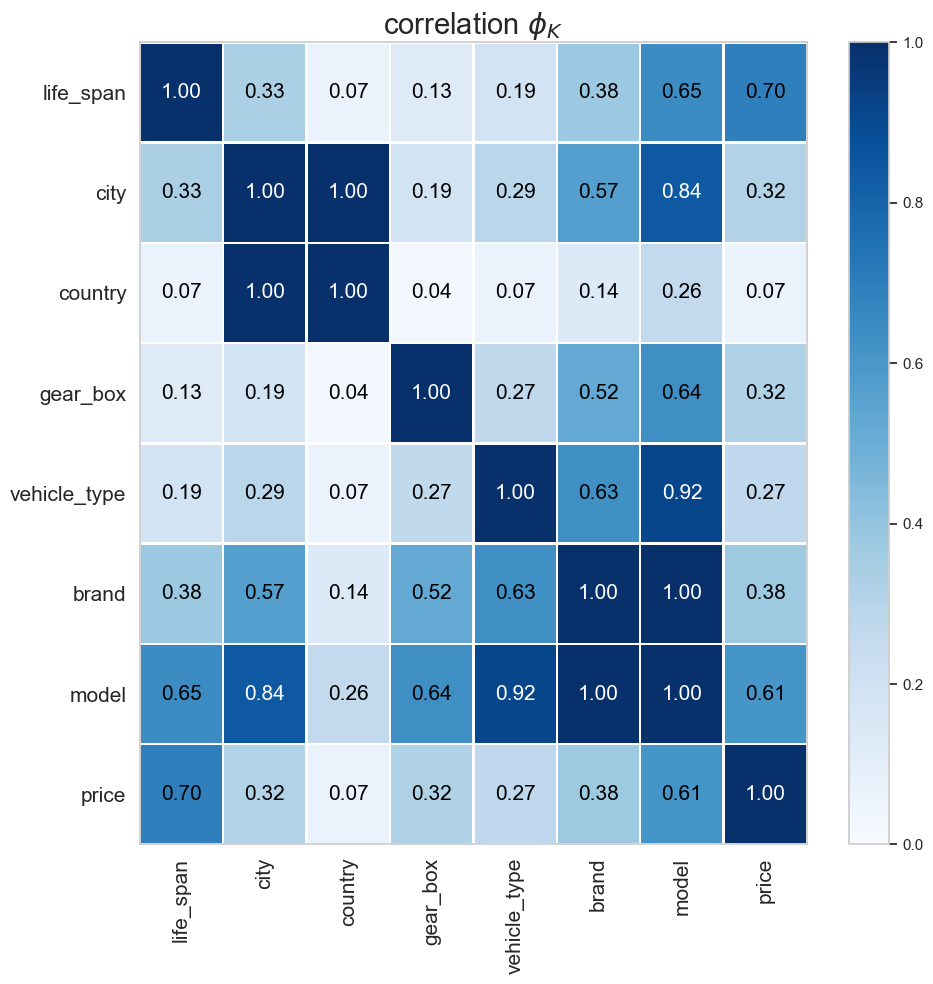

In [66]:
phik = phik_matrix(auto[['price', 'model', 'brand', 'vehicle_type','gear_box', 'country','city','life_span']])
plot_correlation_matrix(phik.values, 
                        x_labels=phik.columns, 
                        y_labels=phik.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r'correlation $\phi_K$', 
                        fontsize_factor=1.5, 
                        figsize=(10, 10))
plt.tight_layout()

Как видим корреляция достаточно приличная для всех категориальных признаков. Так же можем наблюдать высокую корреляцию между признаками **model** и **brand** и **city и country** тоже, поэтому объединим эти столбцы в один. 

**Рассмотрим числовые признаки**

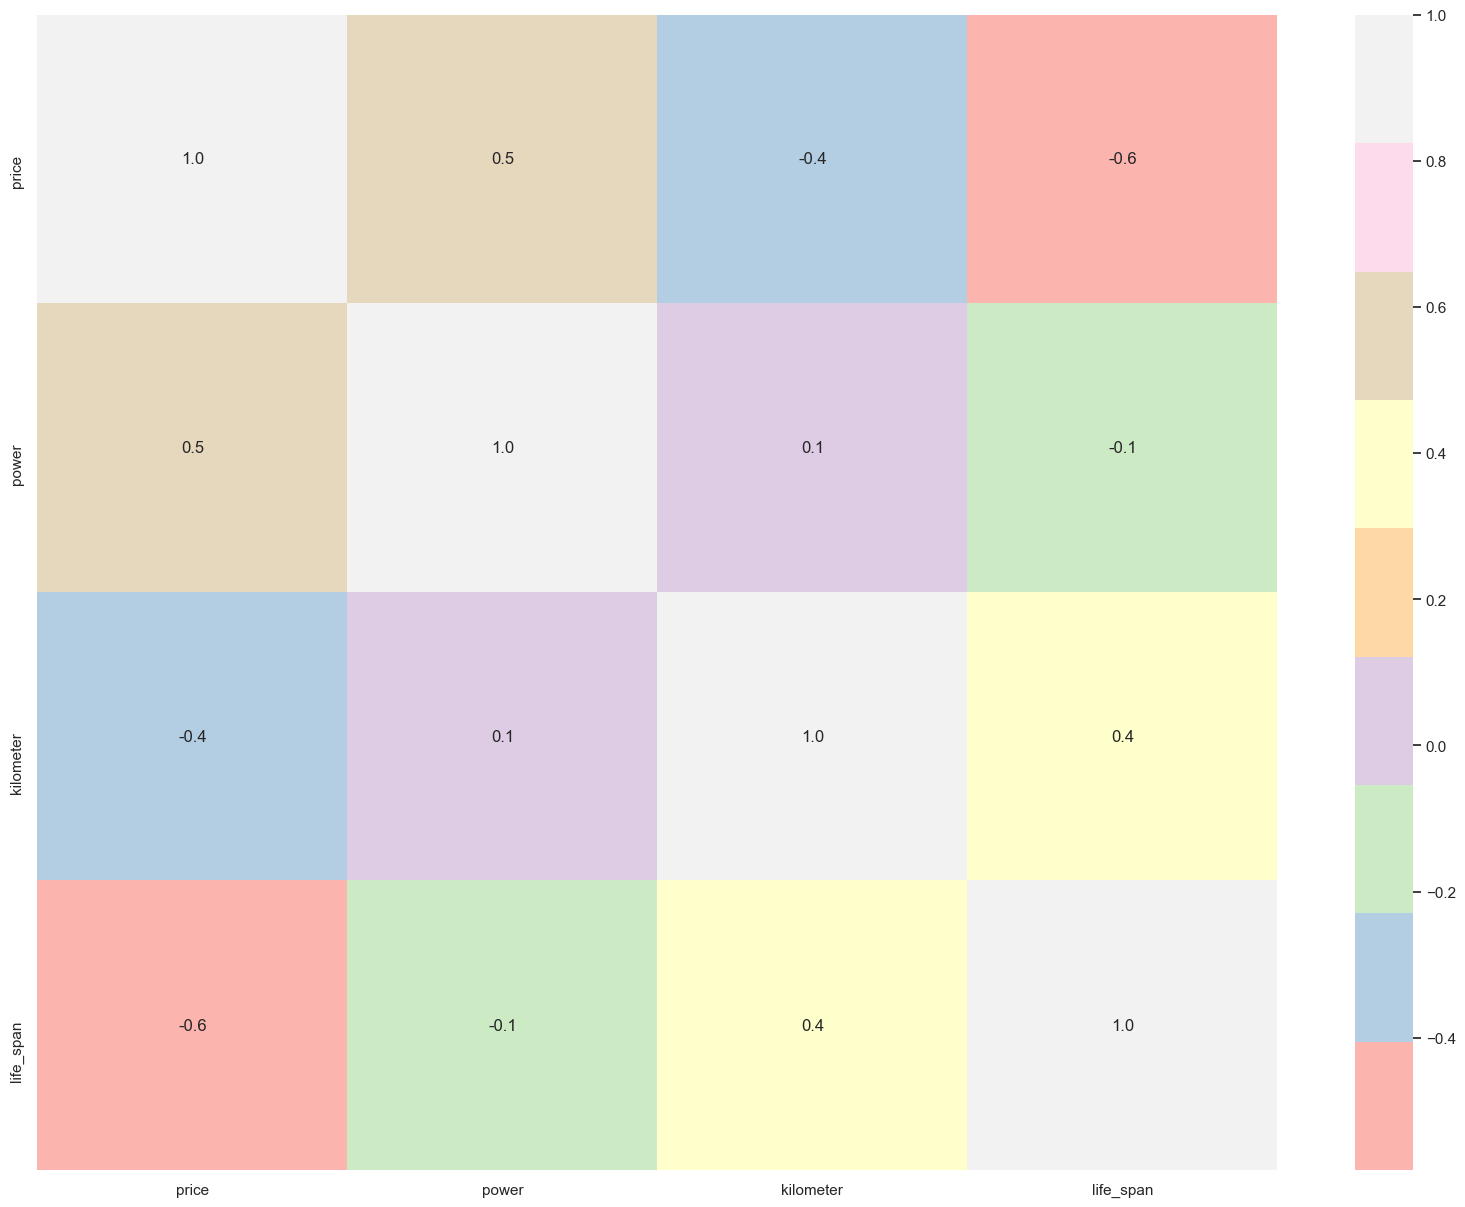

In [67]:
cols = list(auto.select_dtypes(include='int64').columns)
num
sns.set(rc={'figure.figsize': (20,15)})
sns.heatmap(data=auto[cols].corr(), annot=True, fmt='.1f', cmap=sns.color_palette('Pastel1'));

**Напишем функцию для заполнения наших пропусков в данных:**


Так как природу пропусков нам достоверно узнать не имеется возможности, заполним их заглушкой.

In [68]:
def fillna_missing(df):
    df['repaired'] = df['repaired'].fillna('unknown')
    df['model'] = df['model'].fillna('unknown')
    df['gear_box'] = df['gear_box'].fillna('unknown')
    df['vehicle_type'] = df['vehicle_type'].fillna('unknown')
    df['fuel_type'] = df['fuel_type'].fillna('unknown')
    return(df)

In [69]:
auto = fillna_missing(auto)

In [70]:
auto['car_model'] = auto['brand'] + ' ' + auto['model']
auto['location'] = auto['country'] + ' ' + auto['city']

In [72]:
auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 758127 entries, 0 to 758126
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   price         758127 non-null  int64 
 1   vehicle_type  758127 non-null  object
 2   gear_box      758127 non-null  object
 3   power         758127 non-null  int64 
 4   model         758127 non-null  object
 5   kilometer     758127 non-null  int64 
 6   fuel_type     758127 non-null  object
 7   brand         758127 non-null  object
 8   repaired      758127 non-null  object
 9   country       758127 non-null  object
 10  city          758127 non-null  object
 11  life_span     758127 non-null  int64 
 12  car_model     758127 non-null  object
 13  location      758127 non-null  object
dtypes: int64(4), object(10)
memory usage: 81.0+ MB


In [73]:
auto.head(3)

,price,vehicle_type,gear_box,power,model,kilometer,fuel_type,brand,repaired,country,city,life_span,car_model,location
0,2238,small,manual,75,corsa,125000,petrol,opel,no,NL,Amsterdam,13,opel corsa,NL Amsterdam
1,2238,small,manual,75,corsa,125000,petrol,opel,no,NO,Oslo,13,opel corsa,NO Oslo
2,1900,sedan,manual,0,golf,150000,gasoline,volkswagen,unknown,NL,Amsterdam,13,volkswagen golf,NL Amsterdam


In [74]:
#напишем функцию для вывода по предобработанному датасету
def print_preprocessing_results(df):
    print("Количество записей в датасете: {}".format(len(df)))
    print("-"*100)
    print("Количество пропущенных значений по столбцам:")
    display(df.isnull().sum())
    print("-"*100)
    print("Типы данных по столбцам:")
    display(df.dtypes)
    print("-"*100)
    print("Описательные статистики:")
    display(df.describe())
    print("-"*100)

In [75]:
print_preprocessing_results(auto)

Количество записей в датасете: 758127
----------------------------------------------------------------------------------------------------
Количество пропущенных значений по столбцам:


price           0
vehicle_type    0
gear_box        0
power           0
model           0
kilometer       0
fuel_type       0
brand           0
repaired        0
country         0
city            0
life_span       0
car_model       0
location        0
dtype: int64

----------------------------------------------------------------------------------------------------
Типы данных по столбцам:


price            int64
vehicle_type    object
gear_box        object
power            int64
model           object
kilometer        int64
fuel_type       object
brand           object
repaired        object
country         object
city            object
life_span        int64
car_model       object
location        object
dtype: object

----------------------------------------------------------------------------------------------------
Описательные статистики:


,price,power,kilometer,life_span
count,"758,127.00","758,127.00","758,127.00","758,127.00"
mean,"4,600.71",110.15,"128,522.85",12.99
std,"4,545.54",61.48,"36,768.88",5.77
min,100.00,0.00,"5,000.00",0.00
25%,"1,200.00",75.00,"125,000.00",9.00
50%,"2,900.00",105.00,"150,000.00",13.00
75%,"6,700.00",143.00,"150,000.00",17.00
max,"20,000.00",500.00,"150,000.00",28.00


----------------------------------------------------------------------------------------------------


# Вывод:
**После подробного изучения данных, и значений в признаках:**

Было выявлено, что данные скорее всего собирались по всему миру. Заполнение признаков разными формами одного, и того же (petrol, gasoline) свидетельствуют об этом.

Плюс пропуски в указании мощности, тоже местами намекают нам на то, что пользователи были явно разноязычными, так как обозначение лошадиных сил в каждой стране разное, и используется разная единица мощности, некоторые значения в этом поле тоже имеют нехарактерные цифры. 

- Выгрузили из открытых источников файл с индексами всех стран, чтобы просоединить информацию по географическим меткам
- Соединили наши датасеты по индексам
- Выснили что из всех стран Евросоюза у нас только **Нидерланды** 
- Исходя из логики, того, что скорее всего наше приложение планирует разрабатываться в одной их стран евросоюза (прайс в евро) и это Нидерланды.
- Сделали детальное EDA
- Избавились от выбросов
- Создали два новых признака, один из них остенется меткой - продолжительность жизни авто -**'life_span'**
- Второй продолжительность нахождения анкеты на сайте - 'duration', для того чтобы определить адекватность ценового порога. Далее этот признак был удален. Так как до начала тех процесса нам этот пункт неизвестен.
- Так как признаки **model и brand** , **city и country** имеют высокую коррелляцию между друг другом объединим их
- Изобразили интерактивную визуализированную карту по странам 
- Просмотрели корреляцию по Phik для категориальных данных, для числовых по Пиросону
- Удалили признаки с датами и остальные не нужные нам
- Заполнили пропуски заглушками так как природа их неизвестна

Теперь наши данные очищены и полностью готовы к обучению моделей.

## Подготовка данных к машинному обучению

In [77]:
#делим на таргеты и признаки и на тестовую и обучающую выборку
y = auto['price']
X = auto.drop('price', axis=1)

#Разобьем данные сначала на обучающую выборку 75% тестовую 25%
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE)

In [78]:
#сверим размерности
print("Обучающая выборка:", X_train.shape)
print("-"*30)
print("Тестовая выборка:", X_test.shape)
print("-"*30)
print("Обучающая выборка таргет:", y_train.shape)
print("-"*30)
print("Тестовая выборка таргет:", y_test.shape)
print("-"*30)

Обучающая выборка: (568595, 13)
------------------------------
Тестовая выборка: (189532, 13)
------------------------------
Обучающая выборка таргет: (568595,)
------------------------------
Тестовая выборка таргет: (189532,)
------------------------------


In [79]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 568595 entries, 86695 to 260506
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   vehicle_type  568595 non-null  object
 1   gear_box      568595 non-null  object
 2   power         568595 non-null  int64 
 3   model         568595 non-null  object
 4   kilometer     568595 non-null  int64 
 5   fuel_type     568595 non-null  object
 6   brand         568595 non-null  object
 7   repaired      568595 non-null  object
 8   country       568595 non-null  object
 9   city          568595 non-null  object
 10  life_span     568595 non-null  int64 
 11  car_model     568595 non-null  object
 12  location      568595 non-null  object
dtypes: int64(3), object(10)
memory usage: 60.7+ MB


In [80]:
X_train.sample(5)

,vehicle_type,gear_box,power,model,kilometer,fuel_type,brand,repaired,country,city,life_span,car_model,location
283906,unknown,manual,136,a_klasse,150000,petrol,mercedes_benz,no,US,Cleveland,0,mercedes_benz a_klasse,US Cleveland
357991,small,manual,75,corsa,150000,petrol,opel,unknown,US,Iowa Falls,13,opel corsa,US Iowa Falls
274503,suv,auto,224,m_klasse,150000,gasoline,mercedes_benz,no,US,Royalton,8,mercedes_benz m_klasse,US Royalton
417341,unknown,manual,60,golf,150000,petrol,volkswagen,unknown,TR,Demirkaya,0,volkswagen golf,TR Demirkaya
667087,sedan,manual,101,focus,50000,petrol,ford,yes,MX,Real Campestre,10,ford focus,MX Real Campestre


In [81]:
#Выделим категориальные и числовые признаки
cat = list(X_train.select_dtypes(include='object').columns)
num = list(X_train.select_dtypes(include='int64').columns)
print(cat)
num

['vehicle_type', 'gear_box', 'model', 'fuel_type', 'brand', 'repaired', 'country', 'city', 'car_model', 'location']


['power', 'kilometer', 'life_span']

## Обучение моделей

**Создаем препроцессор для кодировщика и стандартизатора**

In [82]:
#создаем pipeline с ColumnTransformer, TargetEncoder, StandardScaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', TargetEncoder(cols=cat))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num),
        ('cat', categorical_transformer, cat)
    ])

**Посмотрим на кросс валидации какие модели возьмем для поиска гиперпараметров, по значению метрики**

# Linear Regression

In [83]:
lr = Pipeline(steps=[
    ('encoder', TargetEncoder(cols=cat)),
    ('regressor', LinearRegression())
])


cvs_lr = cross_val_score(lr, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1).mean()
print("Лучшее значение  линейной регрессии на кросс валидации:", -cvs_lr)

Лучшее значение  линейной регрессии на кросс валидации: 2583.1754112722256


# CatBoostRegression

In [84]:
ct = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(random_state=RANDOM_STATE))
])

cvs_ct = cross_val_score(ct, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1).mean()
print("Лучшее значение  кэтбуст на кросс валидации:", -cvs_ct)

Лучшее значение  кэтбуст на кросс валидации: 1317.6727959189298


# LGBMRegressor

In [85]:
lg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(random_state=RANDOM_STATE))
])

cvs_lg = cross_val_score(lg, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1).mean()
print("Лучшее значение  LGBM на кросс валидации:", -cvs_lg)

Лучшее значение  LGBM на кросс валидации: 1479.5573038528114


# Ridge

In [86]:
rg = Pipeline(steps=[
    ('encoder', TargetEncoder(cols=cat)),
    ('regressor', Ridge())
])


cvs_rg = cross_val_score(rg, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1).mean()
print("Лучшее значение Ridge на кросс валидации:", -cvs_rg)

Лучшее значение Ridge на кросс валидации: 2583.1754122569037


## Вывод:

- После кросс валидации оставляем 3 модели Линейная регрессия (посмотрим на время обучения и предсказания) Кэтбуст и LGBM
- Ridge у нас в аутсайдере

**Поиск гиперпараметров через GridSearchCV и просмотр времени обучения и предсказания**

# Linear Regression

In [87]:
pipe_lr = Pipeline(steps=[
    ('encoder', TargetEncoder(cols=cat)),
    ('regressor', LinearRegression())
])

#задаем параметры для grid search
param_grid = { }

#создаем объект GridSearchCV
grid_search_lr = GridSearchCV(pipe_lr, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

#обучаем модель на тренировочных данных
grid_search_lr.fit(X_train, y_train)

#выводим результаты кросс-валидации
print("Best cross-validation score: ", -grid_search_lr.best_score_)

Best cross-validation score:  2583.1754112722256


In [88]:
cv_results_lr = grid_search_lr.cv_results_
print("Среднее время обучения LinearRegression:", cv_results_lr['mean_fit_time'].mean())
print("Среднее время предсказания LinearRegression:", cv_results_lr['mean_score_time'].mean())

Среднее время обучения LinearRegression: 14.140474414825439
Среднее время предсказания LinearRegression: 0.7174905300140381


# CatBoostRegression

In [89]:
pipe_ct = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(random_state=RANDOM_STATE))
])

#задаем параметры для grid search
param_grid = {
    'regressor__learning_rate': [0.1, 0,3, 0.01],
    'regressor__n_estimators': range(100, 301, 100),
}
# CatBoostRegression
#создаем объект GridSearchCV
grid_search_cb = GridSearchCV(pipe_ct, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

#обучаем модель на тренировочных данных
grid_search_cb.fit(X_train, y_train)

#выводим лучшие параметры и результаты кросс-валидации
print("Best parameters: ", grid_search_cb.best_params_)
print("Best cross-validation score: ", -grid_search_cb.best_score_)


0:	learn: 4239.2838762	total: 214ms	remaining: 1m 4s
1:	learn: 3966.2272748	total: 263ms	remaining: 39.2s
2:	learn: 3720.2934285	total: 310ms	remaining: 30.7s
3:	learn: 3502.1425470	total: 363ms	remaining: 26.9s
4:	learn: 3306.2390725	total: 411ms	remaining: 24.3s
5:	learn: 3131.9123232	total: 470ms	remaining: 23s
6:	learn: 2980.7078501	total: 530ms	remaining: 22.2s
7:	learn: 2845.2693506	total: 592ms	remaining: 21.6s
8:	learn: 2726.8479314	total: 648ms	remaining: 21s
9:	learn: 2618.9625161	total: 704ms	remaining: 20.4s
10:	learn: 2526.5775313	total: 765ms	remaining: 20.1s
11:	learn: 2447.6602798	total: 816ms	remaining: 19.6s
12:	learn: 2375.3470259	total: 874ms	remaining: 19.3s
13:	learn: 2312.6198242	total: 937ms	remaining: 19.1s
14:	learn: 2257.3179893	total: 1s	remaining: 19s
15:	learn: 2209.2681007	total: 1.05s	remaining: 18.7s
16:	learn: 2161.7152349	total: 1.11s	remaining: 18.5s
17:	learn: 2119.6066418	total: 1.17s	remaining: 18.4s
18:	learn: 2086.7789735	total: 1.23s	remaining:

153:	learn: 1547.5203796	total: 8.65s	remaining: 8.2s
154:	learn: 1546.4541571	total: 8.71s	remaining: 8.15s
155:	learn: 1545.4509924	total: 8.76s	remaining: 8.09s
156:	learn: 1544.0746874	total: 8.82s	remaining: 8.03s
157:	learn: 1543.0266812	total: 8.87s	remaining: 7.97s
158:	learn: 1542.0600033	total: 8.93s	remaining: 7.92s
159:	learn: 1540.9352019	total: 8.98s	remaining: 7.86s
160:	learn: 1539.5738494	total: 9.04s	remaining: 7.8s
161:	learn: 1538.3907661	total: 9.09s	remaining: 7.75s
162:	learn: 1537.3979594	total: 9.15s	remaining: 7.69s
163:	learn: 1536.6697128	total: 9.21s	remaining: 7.63s
164:	learn: 1535.8821317	total: 9.26s	remaining: 7.57s
165:	learn: 1534.9133529	total: 9.31s	remaining: 7.52s
166:	learn: 1533.9155971	total: 9.38s	remaining: 7.47s
167:	learn: 1533.2030776	total: 9.43s	remaining: 7.41s
168:	learn: 1532.3874687	total: 9.48s	remaining: 7.35s
169:	learn: 1531.4597142	total: 9.54s	remaining: 7.29s
170:	learn: 1530.3502780	total: 9.59s	remaining: 7.24s
171:	learn: 

In [90]:
cv_results_cb = grid_search_cb.cv_results_
print("Среднее время обучения Catboost:", cv_results_cb['mean_fit_time'].mean())
print("Среднее время предсказания Catboost:", cv_results_cb['mean_score_time'].mean())

Среднее время обучения Catboost: 66.42288002173106
Среднее время предсказания Catboost: 1.4777234236399333


# LGBMRegressor

In [91]:
pipe_lg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(random_state=RANDOM_STATE))
])

#задаем параметры для grid search
param_grid = {
    'regressor__learning_rate': [0.1, 0.2],
    'regressor__n_estimators' : range(100, 400, 50),
    'regressor__max_depth' : range(10, 16 , 5),
}

#создаем объект GridSearchCV
grid_search_lgbm = GridSearchCV(pipe_lg, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

#обучаем модель на тренировочных данных
grid_search_lgbm.fit(X_train, y_train)

#выводим лучшие параметры и результаты кросс-валидации
print("Best parameters: ", grid_search_lgbm.best_params_)
print("Best cross-validation score: ", -grid_search_lgbm.best_score_)


Best parameters:  {'regressor__learning_rate': 0.2, 'regressor__max_depth': 15, 'regressor__n_estimators': 350}
Best cross-validation score:  1239.3067412674966


In [92]:
cv_results_lgbm = grid_search_lgbm.cv_results_
print("Среднее время обучения LGBM:", cv_results_lgbm['mean_fit_time'].mean())
print("Среднее время предсказания LGBM:", cv_results_lgbm['mean_score_time'].mean())

Среднее время обучения LGBM: 40.84164774616559
Среднее время предсказания LGBM: 4.7563767294089


## Анализ моделей

# Предварительный вывод:

- Вырвалась вперед у нас модель от LGBM с неплохой скоростью обучения - 40.84 и предсказания - 4.75, плюс точность неплохая rmse - 1239.306
- Кэтбуст тоже показал неплохие результаты но скорость обучения гораздо хуже

**Создадим бэггинг из наших двух лучших моделей**

# LGBMRegressor &  CatBoostRegression Bagging

In [93]:
#создаем базовые модели
catboost = CatBoostRegressor(learning_rate=0.1, n_estimators=300, random_state=RANDOM_STATE)
lgbm = LGBMRegressor(learning_rate=0.2, max_depth=15, n_estimators=350, random_state=RANDOM_STATE)

#создаем бэггинг-модель, используя базовые модели
bagging = BaggingRegressor(base_estimator=lgbm, n_estimators=6)

#создаем метрику 'neg_root_mean_squared_error'
# scoringg = make_scorer(lambda y_true, y_pred: -mean_squared_error(y_true, y_pred, squared=False), greater_is_better=False)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('bagging', bagging)
])


param_grid = { }

#создаем объект GridSearchCV
search_bagging = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, refit=True)

#обучаем модель на тренировочных данных
search_bagging.fit(X_train, y_train)

#выводим результаты кросс-валидации
print("Best cross-validation score: ", -search_bagging.best_score_)



Best cross-validation score:  1228.7797946503151


In [94]:
cv_results_bagging = search_bagging.cv_results_
print("Среднее время обучения Bagging:", cv_results_bagging['mean_fit_time'].mean())
print("Среднее время предсказания Bagging:", cv_results_bagging['mean_score_time'].mean())

Среднее время обучения Bagging: 126.38346900939942
Среднее время предсказания Bagging: 21.54543333053589


**Вышел хороший скор 1228.779, но время обучения -  126.38 не быстро**

# Тест модели:

In [95]:
%%time
bg_test = search_bagging.best_estimator_.predict(X_test)
RMSE = mean_squared_error(y_test, bg_test, squared=False)
print('RMSE bagging тест равен:', round(RMSE, 2))

RMSE bagging тест равен: 1213.02
CPU times: total: 38.5 s
Wall time: 6.28 s


In [96]:
%%time
test_lg = grid_search_lgbm.best_estimator_.predict(X_test)
RMSE = mean_squared_error(y_test, test_lg, squared=False)
print('RMSE LGBM тест равен:', round(RMSE, 2))

RMSE LGBM тест равен: 1226.16
CPU times: total: 7.42 s
Wall time: 2.05 s


# Константная модель:

In [97]:
dummy = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor',DummyRegressor(strategy="mean"))
])

dummy.fit(X_train, y_train)

test_model = dummy.predict(X_test)

RMSE = mean_squared_error(y_test, test_model, squared=False)

print('RMSE DummyRegressor равен:', round(RMSE, 2))


RMSE DummyRegressor равен: 4543.63


### Общий вывод:

- Наша модель адекватна и по итогу победителем стала модель LGBMRegressor с гиперпараметрами (learning_rate=0.2, max_depth=15, n_estimators=350, random_state=555) 
- Скорость обучения 40.84 с
- Скорость предсказания 4.75 с
- Точность предсказания RMSE на тесте 1226.16